In [203]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import pymdp
from pymdp import utils

# Utilities

In [204]:
def get_most_probable_indices(qs):
    return [np.argmax(q) for q in qs]

In [205]:
def get_max_prob_index(prob_array):
    return int(np.argmax(prob_array))

In [206]:
def step_print(produzione1, produzione2, segnale1, segnale2, vendite1, vendite2, magazzino1, magazzino2, ware_levels):
    print(f"Produzione 1: {produzione1}, Produzione 2: {produzione2}")
    print(f"Segnale analisi 1: {segnale1}, Segnale analisi 2: {segnale2}")
    print(f"Vendite 1: {vendite1}, Vendite 2: {vendite2}")
    print(f"Magazzino 1: {magazzino1, ware_levels[0]}, Magazzino 2: {magazzino2, ware_levels[1]}")
    print("--------------------------------------------------")

In [207]:
def return_level(warehouses,pf_lev, ic_lev, oc_lev):
    levels = [""] * len(warehouses)
    for i,j in enumerate(warehouses):
        if j < pf_lev:
            levels[i] = "perfect"
        elif pf_lev-1 < j < ic_lev:
            levels[i] = "in control"
        elif j > oc_lev:
            levels[i] = "out of control"
        else:
            levels[i] = "loading"
    return levels

In [208]:
def revenue(market_price, sales): 
    C_gain = (market_price)*sales 
    return C_gain

In [209]:
from river.preprocessing import StandardScaler
from river.drift import ADWIN
from river.ensemble import SRPRegressor
from river.tree import HoeffdingTreeRegressor

SRP_1 = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))

SRP_2 = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,               
            )            
        ))

In [210]:
def revenue_SRP(SRP_model, my_sales, sales_competitor):
    gains = []
    for prod in my_sales:
        # Create a feature dictionary for each instance.
        # Adjust the key names according to your feature naming.
        instance = {
            'prod_1': prod,
            'prod_2': sales_competitor,
        }
        # Predict the market price for this instance.
        predicted_price = SRP_model.predict_one(instance)
        # Compute the gain for this production level.
        c_gain = (predicted_price) * prod 
        gains.append(c_gain)
    return np.array(gains)

In [211]:
def build_transition_matrix(preferred_sales, state_warehouse, action_production, size_warehouse, std_dev=1.0):
    """
    Costruisce la matrice di transizione B[s', s, a] che assegna una probabilità
    a ogni stato successivo s' dato uno stato s e un'azione a.
    
    Parameters:
    - preferred_sales: int, il livello di magazzino desiderato
    - state_warehouse: list o array degli stati del magazzino
    - action_production: list o array delle azioni di produzione
    - size_warehouse: int, dimensione massima del magazzino
    - std_dev: float, deviazione standard del rumore nella transizione
    
    Returns:
    - B: ndarray tridimensionale (s', s, a)
    """
    B = np.zeros((len(state_warehouse), len(state_warehouse), len(action_production)))

    for s in range(len(state_warehouse)):
        for a in range(len(action_production)):
            mu = s + a - preferred_sales
            mu = np.clip(mu, 0, size_warehouse - 1)

            for s_prime in range(len(state_warehouse)):
                prob = norm.pdf(s_prime, loc=mu, scale=std_dev)
                B[s_prime, s, a] = prob

            # Normalizzazione per avere distribuzione di probabilità
            B[:, s, a] /= B[:, s, a].sum()

    return B


# States, Observations and Actions

## States

In [212]:
max_warehouse = 10
size_warehouse = max_warehouse + 1
max_production = 6
n_action = max_production + 1

# states
state_warehouse = np.arange(0, size_warehouse)
state_context = ['OK production', 'Reduce production']
state_epistemic = ['Epistemic', 'Non-epistemic']


# number of states
n_states = [len(state_warehouse), len(state_context), len(state_epistemic)]

# number of factors
n_factors = len(n_states)

## Actions

In [213]:
# production 
action_production = np.arange(0, n_action)
action_context = ['DN']
action_analysis = ['Do nothing', 'Ware analysis']

# number of actions
n_controls = [len(action_production), len(action_analysis)]

## Observations

In [214]:
# my items sold
obs_sales = np.arange(0, size_warehouse)
obs_last_production = np.arange(0, n_action)
obs_level_ware = ["perfect", "in control", "loading", "out of control"]
obs_analysis = ["Null", "Analysis"]

num_obs = [len(obs_sales), len(obs_last_production), len(obs_level_ware), len(obs_analysis)]
num_modalities = len(num_obs)

## BR dynamics

In [215]:
assumed_market_price_1 = 30
assumed_market_price_2 = 30
cost_prod_1 = 16
cost_prod_2 = 17
max_customer_price = 30
sensibility = 1
BR_1 = (max_customer_price - 2 * cost_prod_1 + cost_prod_2) / (3*sensibility)
BR_2 = (max_customer_price - 2 * cost_prod_2 + cost_prod_1) / (3*sensibility)
BR_1_idx = round(BR_1)
BR_2_idx = round(BR_2)
print(f'Best response for industry 1: {BR_1}')
print(f'Best response for industry 2: {BR_2}')

# assumed_market_price_1 = 30
# assumed_market_price_2 = 30
# cost_prod_1 = 19
# cost_prod_2 = 20
# max_customer_price = 30
# sensibility = 1
# # BR_1 = min(n_action-1, (max_customer_price - 2 * cost_prod_1 + cost_prod_2) / (3*sensibility))
# # BR_2 = min(n_action-1, (max_customer_price - 2 * cost_prod_2 + cost_prod_1) / (3*sensibility))
# BR_1 = (max_customer_price - 2 * cost_prod_1 + cost_prod_2) / (3*sensibility)
# BR_2 = (max_customer_price - 2 * cost_prod_2 + cost_prod_1) / (3*sensibility)
# BR_1_idx = round(BR_1)
# BR_2_idx = round(BR_2)
# print(f'Best response for industry 1: {BR_1}')
# print(f'Best response for industry 2: {BR_2}')

Best response for industry 1: 5.0
Best response for industry 2: 4.0


# Likelihood matrices

In [216]:
A1 = utils.obj_array(num_modalities)
A2 = utils.obj_array(num_modalities)

## A[sales]

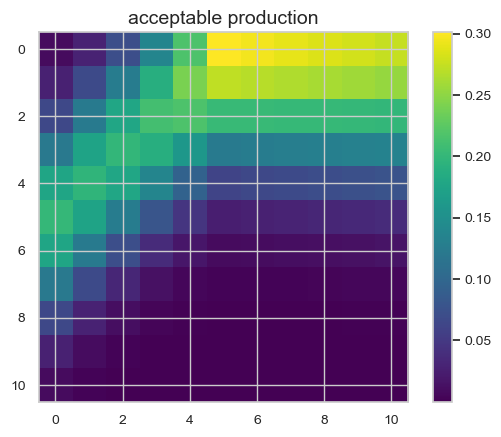

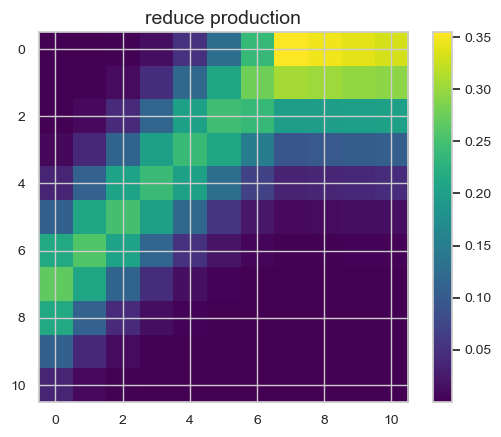

In [217]:
A1_sales = np.zeros((len(obs_sales),len(state_warehouse), len(state_context), len(state_epistemic)))
A2_sales = np.zeros((len(obs_sales),len(state_warehouse), len(state_context), len(state_epistemic)))

for i, state in enumerate(state_context):

    if state == 'OK production':
        soglia = 5  # soglia dopo la quale la media resta fissa
        base_std = 2  # deviazione standard iniziale
        std_growth = 0.05  # crescita della deviazione standard dopo la soglia
    else:
        soglia = 7  # soglia dopo la quale la media resta fissa
        base_std = 1.5  # deviazione standard iniziale
        std_growth = 0.05  # crescita della deviazione standard dopo la soglia

    for idx, epist in enumerate(state_epistemic):

        for j, n in enumerate(state_warehouse):

            mu = max(0, soglia-n)
            sigma = base_std + std_growth * n  # decresce con n

            # Calcolo la distribuzione normale per ogni valore di vendita osservata
            A1_sales[:, j, i, idx] = norm.pdf(obs_sales, loc=mu, scale=sigma)

            # Normalizzo la colonna per renderla una distribuzione di probabilità
            A1_sales[:, j, i, idx] /= A1_sales[:, j, i, idx].sum()


A1[0] = A1_sales
A2[0] = A1_sales

matrix = A1_sales[:,:,0,0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("acceptable production")
plt.show()

matrix = A1_sales[:,:,1,0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("reduce production")
plt.show()

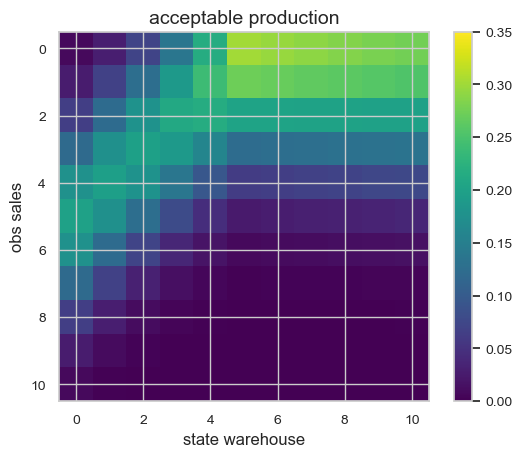

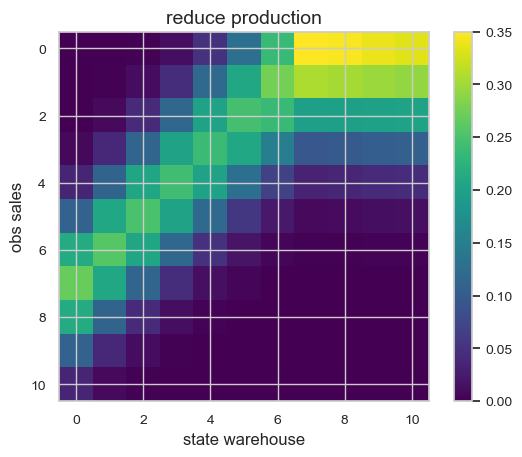

In [218]:
# Common color scale limits
vmin = 0.0
vmax = 0.35

# First plot: acceptable production
matrix = A1_sales[:, :, 0, 0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("acceptable production")
plt.show()

# Second plot: reduce production
matrix = A1_sales[:, :, 1, 0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("reduce production")
plt.show()

## A[last action]

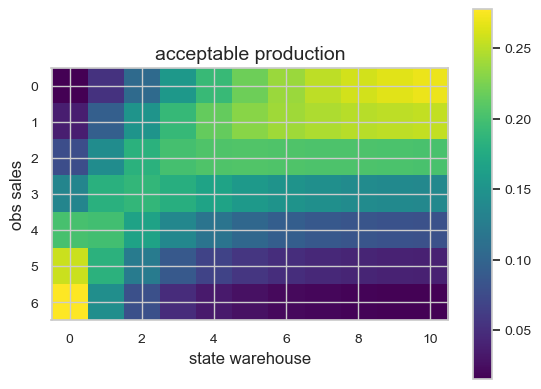

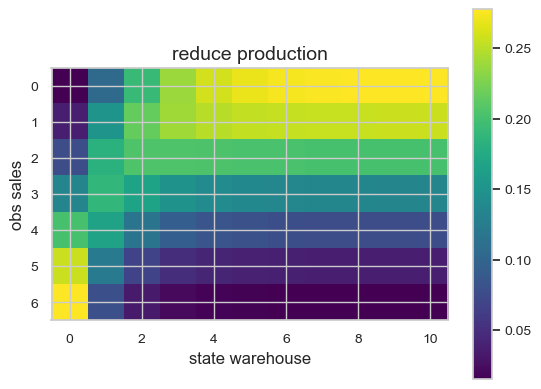

In [219]:
A1_production = np.zeros((len(obs_last_production),len(state_warehouse), len(state_context), len(state_epistemic)))
A2_production = np.zeros((len(obs_last_production),len(state_warehouse), len(state_context), len(state_epistemic)))



for i, state in enumerate(state_context):

    if state == 'OK production':
        max_prod = n_action - 1
        base_std = 2.5  # deviazione standard
        reverse_strength = 4.0  # quanto velocemente la media scende
    else:
        max_prod = n_action - 1
        base_std = 2.5  # deviazione standard
        reverse_strength = 8.0  # quanto velocemente la media scende

    for idx, epist in enumerate(state_epistemic):
        
        for j, n in enumerate(state_warehouse):
            # La media della produzione cala linearmente col magazzino
            mu = max_prod * np.exp(-reverse_strength * n / state_warehouse[-1])
            sigma = base_std

            A1_production[:, j, i, idx] = norm.pdf(obs_last_production, loc=mu, scale=sigma)
            A1_production[:, j, i, idx] /= A1_production[:, j, i, idx].sum()


A1[1] = A1_production
A2[1] = A1_production

matrix = A1_production[:,:,0,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("acceptable production")
plt.show()

matrix = A1_production[:,:,1,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("reduce production")
plt.show()

## A[level_ware]

In [220]:
pf_level = 3
ic_level = 5
oc_level = 8

In [221]:
import numpy as np
import pymdp.utils as utils


# inizializzo la matrice full A1_ware
n_obs    = len(obs_level_ware)
n_ware   = len(state_warehouse)
n_ctx    = len(state_context)
n_epist  = len(state_epistemic)

A1_ware = np.zeros((n_obs, n_ware, n_ctx, n_epist))

# ricreo prima la vecchia matrice base senza contesto
A_base = np.zeros((n_obs, n_ware, n_epist))

for idx_e, epist in enumerate(state_epistemic):
    if epist == "Epistemic":
        # caso deterministico
        for j, level in enumerate(obs_level_ware):
            if level == "perfect":
                A_base[j, :pf_level, idx_e] = 1
            elif level == "in control":
                A_base[j, pf_level:ic_level, idx_e] = 1
            elif level == "loading":
                A_base[j, ic_level:oc_level, idx_e] = 1
            elif level == "out of control":
                A_base[j, oc_level:, idx_e] = 1
    else:
        # caso "noisy" basato su slice Epistemic
        noise_std = 0.4
        base = A_base[:, :, state_epistemic.index("Epistemic")]

        for w in range(n_ware):
            col_base = base[:, w]
            centers = np.where(col_base > 0)[0]
            if len(centers) == 0:
                A_base[:, w, idx_e] = 1.0 / n_obs
            else:
                noisy_col = np.zeros(n_obs)
                for c0 in centers:
                    distances = np.abs(np.arange(n_obs) - c0)
                    gaussian = np.exp(-(distances**2) / (2 * noise_std**2))
                    noisy_col += gaussian
                noisy_col = np.clip(noisy_col, 0, None)
                noisy_col /= noisy_col.sum()
                A_base[:, w, idx_e] = noisy_col

# definisco i pesi P(context | osservazione)
#    riga = osservazione, colonna = contesto
context_weights = np.array([
    [0.99, 0.01],  # perfect
    [0.80, 0.20],  # in control
    [0.20, 0.80],  # loading
    [0.01, 0.99],  # out of control
])  # shape = (n_obs, n_ctx)

# espando A_base su dimensione contesto e rinormalizzo
for e in range(n_epist):
    for w in range(n_ware):
        base_col = A_base[:, w, e]
        for c in range(n_ctx):
            raw = base_col * context_weights[:, c]
            if raw.sum() == 0:
                # fallback (se per qualche colonna tutti zeri)
                raw = base_col.copy()
            A1_ware[:, w, c, e] = raw / raw.sum()

# assegno alle matrici pymdp
A1[2] = A1_ware
A2[2] = A1_ware

# verifica
assert utils.is_normalized(A1_ware), "A1_ware NON è normalizzata!"


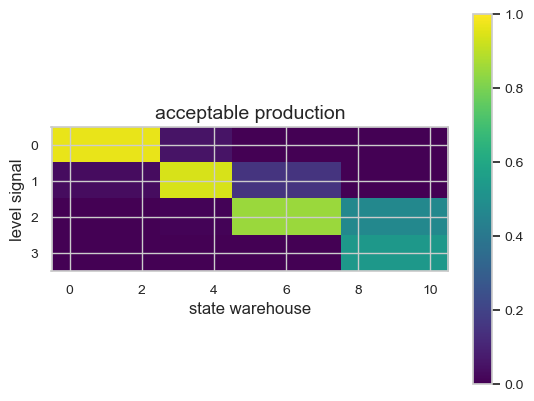

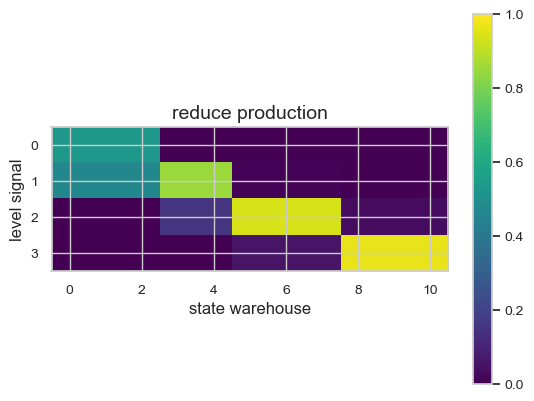

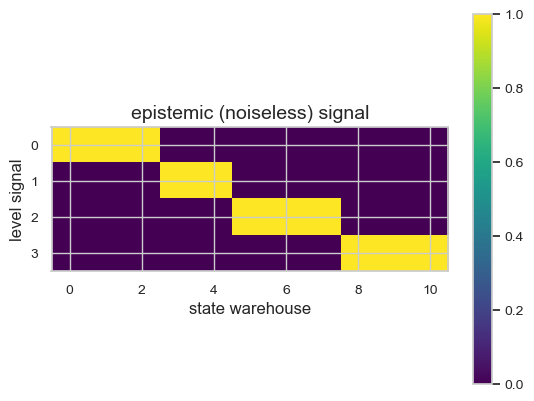

In [222]:
matrix = A1_ware[:,:,0,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("level signal")
plt.xlabel("state warehouse")
plt.title("acceptable production")
#plt.title("Produzione OK - Segnale rumoroso")
plt.show()

matrix = A1_ware[:,:,1,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("level signal")
plt.xlabel("state warehouse")
plt.title("reduce production")
# plt.title("Riduzione della produzione - Segnale rumoroso")
plt.show()

matrix = A1_ware[:,:,0,0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("level signal")
plt.xlabel("state warehouse")
plt.title("epistemic (noiseless) signal")
plt.show()

## A[analysis]

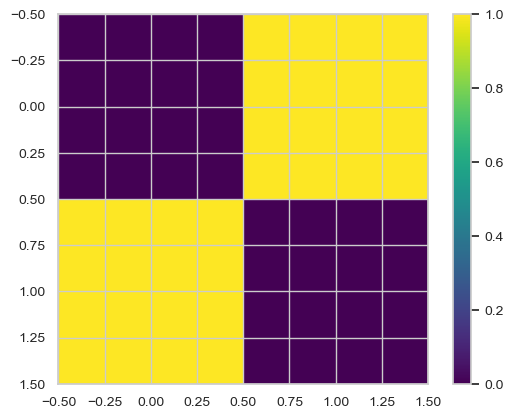

In [223]:
A1_analysis = np.zeros((len(obs_analysis),len(state_warehouse),len(state_context),len(state_epistemic)))
A2_analysis = np.zeros((len(obs_analysis),len(state_warehouse),len(state_context),len(state_epistemic)))

for j, state in enumerate(state_context):
    for i, ware in enumerate(state_warehouse):
        A1_analysis[1,i,j,0] = 1
        A1_analysis[0,i,j,1] = 1

A1[3] = A1_analysis
A2[3] = A1_analysis

matrix = A1_analysis[:,6,1,:]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

# Transition probabilities matrices

In [224]:
B1 = utils.obj_array(n_factors)
B2 = utils.obj_array(n_factors)

## B[warehouse]

In [225]:
B_warehouse1 = np.zeros((len(state_warehouse), len(state_warehouse), len(action_production)))

preferred_sales = BR_1_idx  # vogliamo andare verso s-2
# Parametro di rumore
std_dev = 1.0  # deviazione standard del rumore

for s in range(len(state_warehouse)):  # Stato iniziale
    for a in range(len(action_production)):  # Azione di produzione

        # Centro della distribuzione = stato + produzione - 2
        mu = s + a - preferred_sales
        mu = np.clip(mu, 0, size_warehouse - 1)

        for s_prime in range(len(state_warehouse)):
            prob = norm.pdf(s_prime, loc=mu, scale=std_dev)
            B_warehouse1[s_prime, s, a] = prob

        # Normalizza la colonna per renderla una distribuzione di probabilità
        B_warehouse1[:, s, a] /= B_warehouse1[:, s, a].sum()

In [226]:
B_warehouse2 = np.zeros((len(state_warehouse), len(state_warehouse), len(action_production)))

preferred_sales = BR_2_idx  # vogliamo andare verso s-2
# Parametro di rumore
std_dev = 1.0  # deviazione standard del rumore

for s in range(len(state_warehouse)):  # Stato iniziale
    for a in range(len(action_production)):  # Azione di produzione

        # Centro della distribuzione = stato + produzione - 2
        mu = s + a - preferred_sales
        mu = np.clip(mu, 0, size_warehouse - 1)

        for s_prime in range(len(state_warehouse)):
            prob = norm.pdf(s_prime, loc=mu, scale=std_dev)
            B_warehouse2[s_prime, s, a] = prob

        # Normalizza la colonna per renderla una distribuzione di probabilità
        B_warehouse2[:, s, a] /= B_warehouse2[:, s, a].sum()

In [227]:
B1[0] = B_warehouse1
B2[0] = B_warehouse2

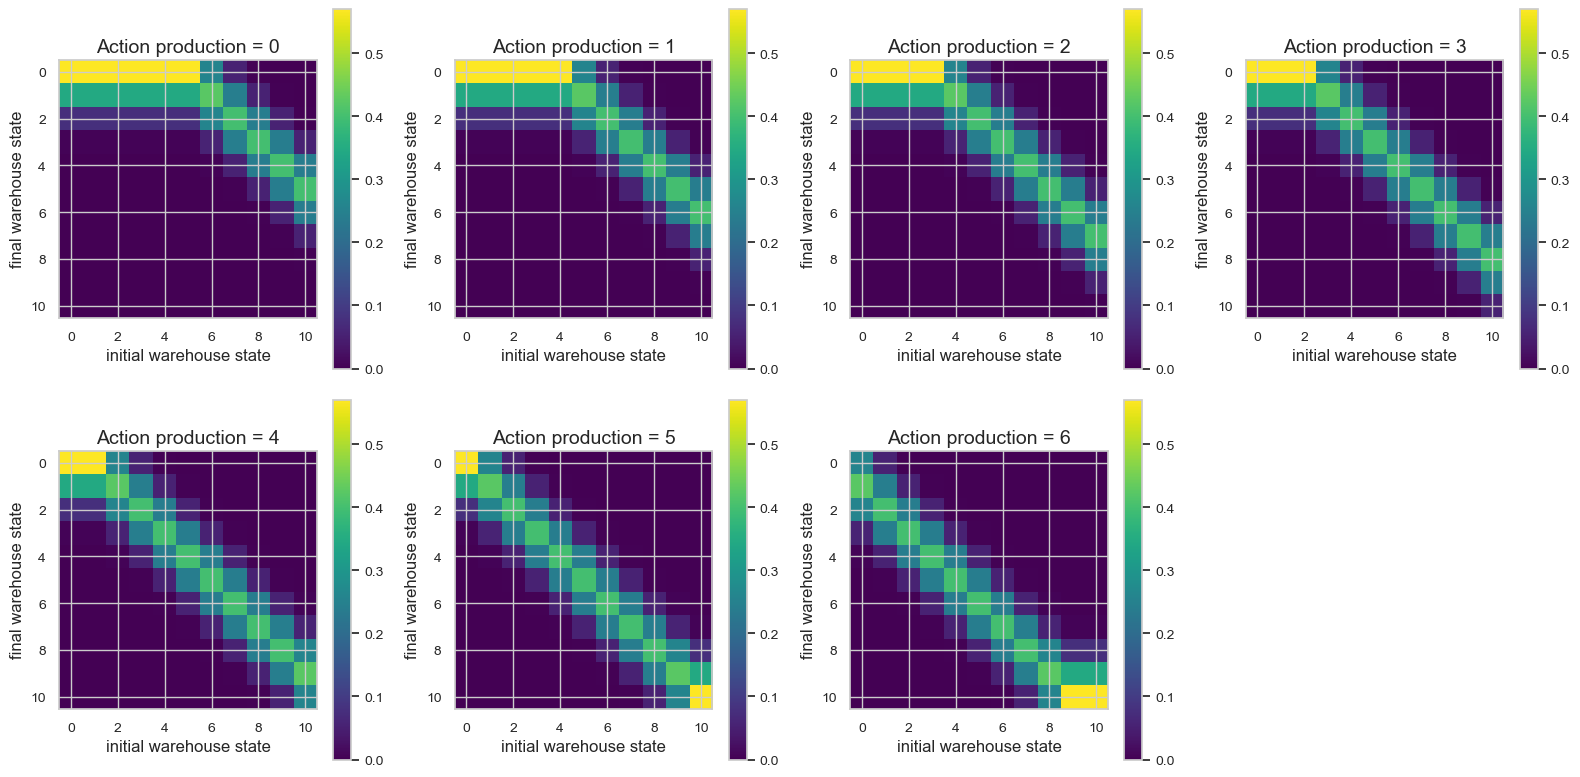

In [228]:
# Determina il numero di righe e colonne per i subplot
matrix = B_warehouse1
n_actions = matrix.shape[2]
n_cols = 4 #int(np.ceil(np.sqrt(n_actions)))
n_rows = 2 #int(np.ceil(n_actions / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Appiattiamo gli assi per iterare facilmente (funziona anche se la griglia non è quadrata)
axes = axes.flatten()

for i in range(n_actions):
    im = axes[i].imshow(matrix[:, :, i], cmap='viridis', interpolation='nearest')
    axes[i].set_title(f'Action production = {i}')
    axes[i].set_xlabel('initial warehouse state')
    axes[i].set_ylabel('final warehouse state')
    fig.colorbar(im, ax=axes[i])

# Nasconde eventuali subplot vuoti
for j in range(n_actions, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## B[context]

In [229]:
B_context = np.zeros((len(state_context), len(state_context), len(action_context)))

p_correct = 0.5 # probabilità che si rimanga nel contesto precedente

for a in range(len(action_context)):
    for s in range(len(state_context)):
        for s_prime in range(len(state_context)):
            if s_prime == s:
                B_context[s_prime, s, a] = p_correct
            else:                    
                B_context[s_prime, s, a] = (1 - p_correct) / (len(state_context) - 1)
        # Normalizza ogni colonna
    B_context[:, :, a] /= B_context[:, :, a].sum(axis=0)

B1[1] = B_context
B2[1] = B_context

## B[state]

In [230]:
B_epistemic = np.zeros((len(state_epistemic), len(state_epistemic), len(action_analysis)))

for i, a in enumerate(action_analysis):
    if a == 'Ware analysis':
        B_epistemic[0,:,i] = 1
    else:
        B_epistemic[1,:,i] = 1 

B1[2] = B_epistemic
B2[2] = B_epistemic

# Goal prior

In [231]:
C1 = utils.obj_array_zeros(num_obs)
C2 = utils.obj_array_zeros(num_obs)

## C[sales]

In [232]:
C_sales_1 = revenue(market_price=assumed_market_price_1, sales=obs_sales)
C_sales_2 = revenue(market_price=assumed_market_price_2, sales=obs_sales)

C1[0] = C_sales_1
C2[0] = C_sales_2

## C[production]

In [233]:
C_production_1 = -cost_prod_1 * action_production
C_production_2 = -cost_prod_2 * action_production

C1[1] = C_production_1
C2[1] = C_production_2

## C[ware]
Se supero una certa soglia magari devo sostenere dei costi di gestione maggiori, se la situazione è critica dei costi di smaltimento.

In [234]:
C_ware = np.array([0, -15, -75, -100])

C1[2] = C_ware
C2[2] = C_ware

## C[analysis]

In [235]:
C_analysis = np.array([0, -3.5])

C1[3] = C_analysis
C2[3] = C_analysis

# State Prior

In [236]:
D1 = utils.obj_array(n_factors)
D2 = utils.obj_array(n_factors)

D_warehouse = utils.onehot(0, len(state_warehouse))
D_context = utils.onehot(0, len(state_context))
D_epistemic = utils.onehot(1, len(state_epistemic))

D1[0] = D_warehouse
D2[0] = D_warehouse

D1[1] = D_context
D2[1] = D_context

D1[2] = D_epistemic
D2[2] = D_epistemic


# Agent initialization

In [237]:
B1_prior = utils.dirichlet_like(B1)
B2_prior = utils.dirichlet_like(B2)

In [238]:
from pymdp.agent import Agent

In [239]:
my_agent1 = Agent(A = A1, B = B1, C = C1, D = D1, policy_len=3,
                  use_states_info_gain = False,
                  use_param_info_gain = True,
                  scale_state=0.1)

In [240]:
my_agent2 = Agent(A = A2, B = B2, C = C2, D = D2, policy_len=3,
                  use_states_info_gain = False,
                  use_param_info_gain = True,
                  scale_state=0.1)

# Environment

In [241]:
class CournotMarket(object):

    def __init__(self, reputation=0.5, total_demand=5, max_customer_price=10, sensibility=1, warehouse_1=0, warehouse_2=0):
        self.reputation = float(reputation)
        self.total_demand = float(total_demand)
        self.max_customer_price = float(max_customer_price)
        self.sensibility = float(sensibility)
        self.warehouse_1 = int(warehouse_1)
        self.warehouse_2 = int(warehouse_2)
    

    def step(self, action1, action2, time_step):
        if time_step == 6:
            self.total_demand = 6
        if time_step == 11: 
            self.total_demand = 4
        if time_step == 15:
            self.total_demand = 14
            self.max_customer_price = 45

        real_total_demand = self.total_demand #+ np.random.random_integers(-1, 1)
        print(f"Real total demand: {real_total_demand}")
        
        total_product_1 = action1[0] + self.warehouse_1
        total_product_2 = action2[0] + self.warehouse_2
        product_availability = total_product_1 + total_product_2
        
        market_price = max(0, self.max_customer_price - self.sensibility * product_availability)
        
        preferred_demand_1 = int(real_total_demand * self.reputation)
        preferred_demand_2 = real_total_demand - preferred_demand_1
        
        actual_sales_1 = min(total_product_1, preferred_demand_1)
        actual_sales_2 = min(total_product_2, preferred_demand_2)
        
        # gente rimasta esclusa dalla vendita della sua azienda preferita
        remaining_demand_1 = preferred_demand_1 - actual_sales_1
        remaining_demand_2 = preferred_demand_2 - actual_sales_2
        
        if remaining_demand_1 > 0 and total_product_2 > actual_sales_2:
            extra_sales_2 = min(total_product_2 - actual_sales_2, remaining_demand_1)
            actual_sales_2 += extra_sales_2
            remaining_demand_1 -= extra_sales_2
        
        if remaining_demand_2 > 0 and total_product_1 > actual_sales_1:
            extra_sales_1 = min(total_product_1 - actual_sales_1, remaining_demand_2)
            actual_sales_1 += extra_sales_1
            remaining_demand_2 -= extra_sales_1
        
        self.warehouse_1 = total_product_1 - actual_sales_1
        self.warehouse_2 = total_product_2 - actual_sales_2

        if action1[2] == 1:
            analysis_1 = "Analysis"
        else:
            analysis_1 = "Null"
        
        if action2[2] == 1:
            analysis_2 = "Analysis"
        else:
            analysis_2 = "Null"

        #print(f'Warehouse: {h_obs_warehouse}')
        obs_sales = [int(actual_sales_1), int(actual_sales_2)] 
        obs_last_prod = [int(action1[0]), int(action2[0])] 
        h_obs_warehouse = [int(self.warehouse_1), int(self.warehouse_2)]
        obs_level_ware = return_level(h_obs_warehouse,pf_level, ic_level, oc_level)
        obs_analysis = [analysis_1, analysis_2]
        return obs_sales, market_price, obs_last_prod, obs_level_ware, obs_analysis, h_obs_warehouse

# Active Inference Loop

In [242]:
prod1 = []
prod2 = []
warehouse1 = [0]
warehouse2 = [0]
sold1 = []
sold2 = []

infer_ware1 = []
infer_ware2 = []

infer_context1 = []
infer_context2 = []

epistemic_choice1 = []
epistemic_choice2 = []

real_price =[]
predicted_price1 = []
predicted_price2 = []

Belief_gain1 =[]
real_gain1 = []

Belief_gain2 =[]    
real_gain2 = []

Max_price = []

In [243]:
def run_active_inference_loop(my_agent1, my_agent2, my_env, size_warehouse, T=5):
    """Runs an active inference loop where alpha increases over time."""

    market_price = assumed_market_price_1
    size_ware = size_warehouse
    size_warehouse = np.arange(size_warehouse)
    obs1 = [0, 0, obs_level_ware.index("perfect"), obs_analysis.index("Null")] 
    obs2 = [0, 0, obs_level_ware.index("perfect"), obs_analysis.index("Null")]

    starting_sales_states = [0, 0]
    obs_last_sales = starting_sales_states

    starting_sales_states = [0, 0]
    obs_last_sales = starting_sales_states

    null_instance = {f"prod_{i}": v for i, v in enumerate(obs_last_sales)}

    SRP_1.learn_one(null_instance, market_price)
    SRP_2.learn_one(null_instance, market_price)

    old_max_price_1 = SRP_1.predict_one(null_instance) 
    old_max_price_2 = SRP_2.predict_one(null_instance) 


    for t in range(T):
        qs_ware1, qs_ctx1, qs_epist1 = my_agent1.infer_states(obs1)
        qs_ware2, qs_ctx2, qs_epist2 = my_agent2.infer_states(obs2)
        print("supposed warehouse 1:", get_max_prob_index(qs_ware1))
        print("context 1:", get_max_prob_index(qs_ctx1))
        print("analisi 1:", get_max_prob_index(qs_epist1))
        print("supposed warehouse 2:", get_max_prob_index(qs_ware2))
        print("context 2:", get_max_prob_index(qs_ctx2))
        print("analisi 2:", get_max_prob_index(qs_epist2))
        
        # Update preference distribution (C matrix) using a custom revenue function
        my_agent1.C[0] = revenue_SRP(SRP_1, my_sales=size_warehouse, sales_competitor=obs_last_sales[1])
        my_agent2.C[0] = revenue_SRP(SRP_2, my_sales=size_warehouse, sales_competitor=obs_last_sales[0])

        # Infer policies
        q_pi_1, efe_1 = my_agent1.infer_policies()
        q_pi_2, efe_2 = my_agent2.infer_policies()

        # Sample actions based on stochastic policy selection
        action_1 = my_agent1.sample_action()
        action_2 = my_agent2.sample_action()
        
        # Environment step
        obs_sales, market_price, obs_last_prod, obs_level, obs_analysis_signal, h_obs_warehouse = my_env.step(action_1, action_2, t)

        step_print(produzione1=obs_last_prod[0], produzione2=obs_last_prod[1], 
                   segnale1=obs_analysis_signal[0], segnale2=obs_analysis_signal[1],
                   vendite1=obs_sales[0], vendite2=obs_sales[1], 
                   magazzino1=h_obs_warehouse[0], magazzino2=h_obs_warehouse[1],
                   ware_levels=obs_level)

        instance = {f"prod_{i}": v for i, v in enumerate(obs_sales)}

        price_hat_1 = SRP_1.predict_one(instance)
        price_hat_2 = SRP_2.predict_one(instance)
        SRP_1.learn_one(instance, market_price)
        SRP_2.learn_one(instance, market_price)

        #---------- Update B (if needed) ----------------#
        Max_price.append(SRP_1.predict_one(null_instance))
        
        new_max_price_1 = SRP_1.predict_one(null_instance) + 5
        new_max_price_2 = SRP_2.predict_one(null_instance) + 5

        
        print("old max price 1:", old_max_price_1)
        print("new max price 1:", new_max_price_1)
        print("old max price 2:", old_max_price_2)
        print("new max price 2:", new_max_price_2)

        if (abs(new_max_price_1 - old_max_price_1))/old_max_price_1 > 0.2:
            BR_1 = (new_max_price_1 - 2 * cost_prod_1 + cost_prod_2) / (3*sensibility)
            BR_1_idx = round(min(BR_1, max_production))
            print(f"NEW BR 1: {BR_1_idx}")
            B1_new = build_transition_matrix(preferred_sales=BR_1_idx, state_warehouse=state_warehouse, 
                                             action_production=action_production, size_warehouse=size_ware)
            my_agent1.B[0] = B1_new
        
        if (abs(new_max_price_1 - old_max_price_1))/old_max_price_1 > 0.2:
            BR_2 = (new_max_price_2 - 2 * cost_prod_2 + cost_prod_1) / (3*sensibility)
            BR_2_idx = round(min(BR_2, max_production))
            print(f"NEW BR 2: {BR_2_idx}")
            B1_new = build_transition_matrix(preferred_sales=BR_2_idx, state_warehouse=state_warehouse, 
                                             action_production=action_production, size_warehouse=size_ware)
            my_agent2.B[0] = B1_new

        old_max_price_1 = new_max_price_1
        old_max_price_2 = new_max_price_2

        #----------- end update section -----------------#

        # Update observations
        obs1 = [obs_sales[0], obs_last_prod[0], obs_level_ware.index(obs_level[0]), 
                obs_analysis.index(obs_analysis_signal[0])]
        obs2 = [obs_sales[1], obs_last_prod[1], obs_level_ware.index(obs_level[1]), 
                obs_analysis.index(obs_analysis_signal[1])]

        # per il prossimo step di training
        obs_last_sales = obs_sales

        # Plot variables

        # 1) plot about production and sales
        prod1.append(obs_last_prod[0])
        prod2.append(obs_last_prod[1])
        warehouse1.append(h_obs_warehouse[0])
        warehouse2.append(h_obs_warehouse[1])
        sold1.append(obs_sales[0])
        sold2.append(obs_sales[1])
        infer_ware1.append(get_max_prob_index(qs_ware1))
        infer_ware2.append(get_max_prob_index(qs_ware2))

        epistemic_choice1.append(get_max_prob_index(qs_epist1))
        epistemic_choice2.append(get_max_prob_index(qs_epist2))

        infer_context1.append(get_max_prob_index(qs_ctx1))
        infer_context2.append(get_max_prob_index(qs_ctx2))

        # 2) plot about price estimation
        real_price.append(market_price)
        predicted_price1.append(price_hat_1)
        predicted_price2.append(price_hat_2)

# Main


In [244]:
import warnings
warnings.filterwarnings('ignore')

In [245]:
reputation_env = 0.5
total_demand_env = 10
env = CournotMarket(reputation = reputation_env, total_demand = total_demand_env, 
                    max_customer_price = max_customer_price, sensibility = sensibility)

T = 25

run_active_inference_loop(my_agent1, my_agent2, env, size_warehouse=size_warehouse, T = T)

supposed warehouse 1: 0
context 1: 0
analisi 1: 1
supposed warehouse 2: 0
context 2: 0
analisi 2: 1


Real total demand: 10.0
Produzione 1: 6, Produzione 2: 5
Segnale analisi 1: Analysis, Segnale analisi 2: Analysis
Vendite 1: 5, Vendite 2: 5
Magazzino 1: (1, 'perfect'), Magazzino 2: (0, 'perfect')
--------------------------------------------------
old max price 1: 30.0
new max price 1: 29.72809266756635
old max price 2: 30.0
new max price 2: 29.72809266756635
supposed warehouse 1: 0
context 1: 0
analisi 1: 0
supposed warehouse 2: 1
context 2: 0
analisi 2: 0
Real total demand: 10.0
Produzione 1: 5, Produzione 2: 4
Segnale analisi 1: Analysis, Segnale analisi 2: Analysis
Vendite 1: 6, Vendite 2: 4
Magazzino 1: (0, 'perfect'), Magazzino 2: (0, 'perfect')
--------------------------------------------------
old max price 1: 29.72809266756635
new max price 1: 28.008995098039218
old max price 2: 29.72809266756635
new max price 2: 28.008995098039218
supposed warehouse 1: 0
context 1: 1
analisi 1: 0
supposed warehouse 2: 1
context 2: 0
analisi 2: 0
Real total demand: 10.0
Produzione 1: 6, Produ

# Plot

In [246]:
time = np.arange(T)

In [247]:
infer_ware_plot1 = [x + y for x, y in zip(infer_ware1, prod1)]
infer_ware_plot2 = [x + y for x, y in zip(infer_ware2, prod2)]

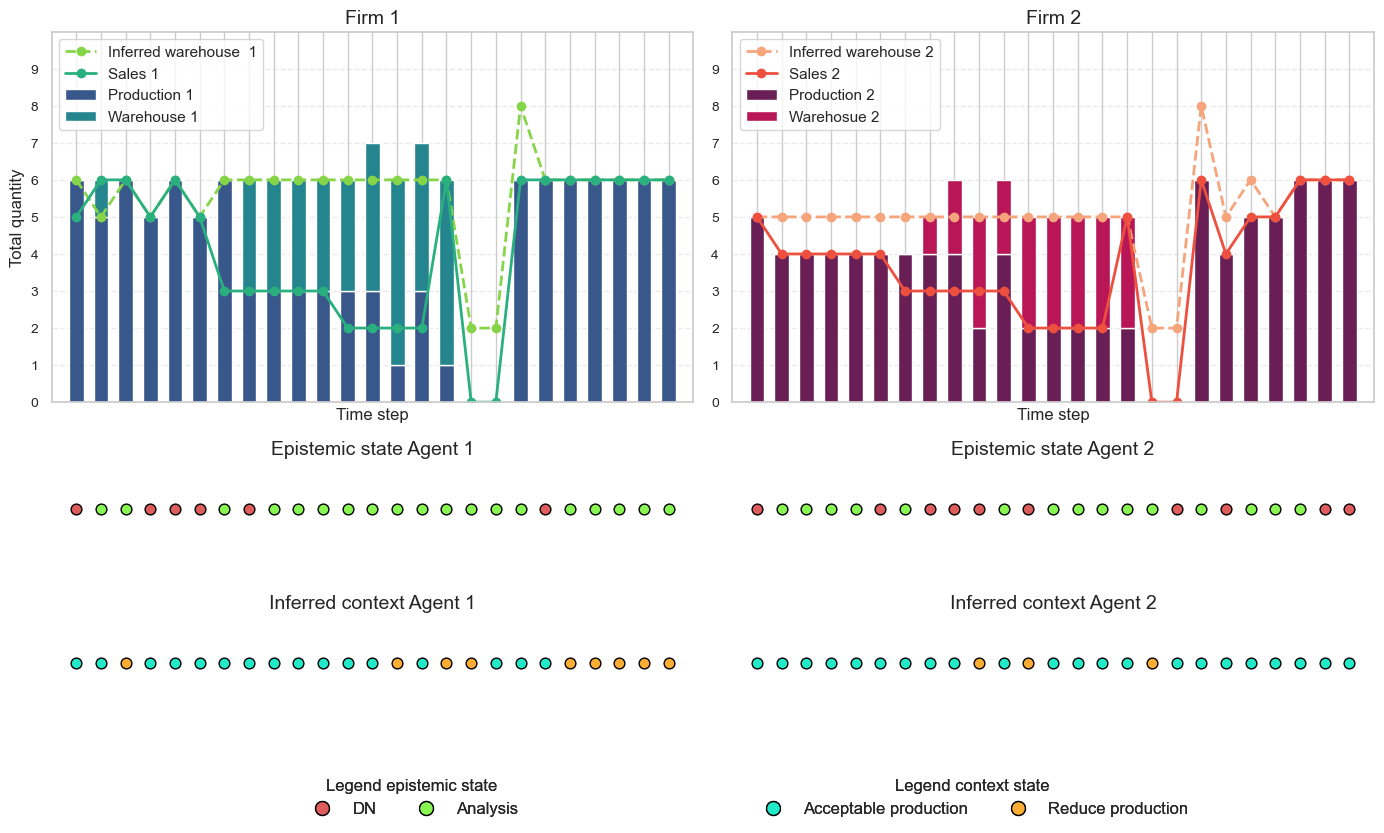

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Setup estetico generale
sns.set(style="whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Asse temporale
bar_width = 0.6

# Colori eleganti per Agente 1 e Agente 2
palette1 = sns.color_palette("viridis", 10)
palette2 = sns.color_palette("rocket", 10)

colors_agent1 = {
    'produzione': palette1[2],
    'magazzino': palette1[4],
    'vendite': palette1[6],
    'inferenza': palette1[8]
}
colors_agent2 = {
    'produzione': palette2[2],
    'magazzino': palette2[4],
    'vendite': palette2[6],
    'inferenza': palette2[8]
}

# Colori epistemici 
color_dn = '#df5c5c'    # rosso elegante
color_analisi = '#89f752'  # verde elegante

# Colori contesto
color_ok = '#21eac9'      # azzurro elegante
color_reduce = '#fcad33'  # arancione elegante

# Crea un layout a 3 righe
# fig, axs = plt.subplots(3, 2, figsize=(16, 13), gridspec_kw={'height_ratios': [4, 1, 1]}, sharex='col')
fig, axs = plt.subplots(3, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [4, 1, 1]}, sharex='col')


# --- Categoria 1 ---
ax1 = axs[0, 0]
ax1.bar(time, prod1, width=bar_width, label='Production 1', color=colors_agent1['produzione'])
ax1.bar(time, warehouse1[0:T], width=bar_width, bottom=prod1, label='Warehouse 1', color=colors_agent1['magazzino'])
ax1.plot(time, infer_ware_plot1, label='Inferred warehouse  1', color=colors_agent1['inferenza'], marker='o', linestyle='--', linewidth=2)
ax1.plot(time, sold1, label='Sales 1', color=colors_agent1['vendite'], marker='o', linestyle='-', linewidth=2)
ax1.set_title('Firm 1')
ax1.set_ylabel('Total quantity')
ax1.set_xlabel('Time step')
ax1.legend(loc='upper left', frameon=True)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax1.set_xticks(time)
ax1.set_xticklabels(time)
ax1.set_yticks(range(10))
ax1.set_ylim(0, 10)

# --- Categoria 2 ---
ax2 = axs[0, 1]
ax2.bar(time, prod2, width=bar_width, label='Production 2', color=colors_agent2['produzione'])
ax2.bar(time, warehouse2[0:T], width=bar_width, bottom=prod2, label='Warehosue 2', color=colors_agent2['magazzino'])
ax2.plot(time, infer_ware_plot2, label='Inferred warehouse 2', color=colors_agent2['inferenza'], marker='o', linestyle='--', linewidth=2)
ax2.plot(time, sold2, label='Sales 2', color=colors_agent2['vendite'], marker='o', linestyle='-', linewidth=2)
ax2.set_title('Firm 2')
ax2.set_xlabel('Time step')
ax2.legend(loc='upper left', frameon=True)
ax2.grid(axis='y', linestyle='--', alpha=0.4)
ax2.set_xticks(time)
ax2.set_xticklabels(time)
ax2.set_yticks(range(10))
ax2.set_ylim(0, 10)

# --- Stato Epistemico Categoria 1 ---
ax3 = axs[1, 0]
for i, val in enumerate(epistemic_choice1):
    color = color_dn if val == 1 else color_analisi
    ax3.scatter(i, 0, color=color, edgecolor='black', s=60)
ax3.set_xlim(-1, T)
ax3.set_ylim(-1, 1)
ax3.axis('off')
ax3.set_title('Epistemic state Agent 1')

# --- Stato Epistemico Categoria 2 ---
ax4 = axs[1, 1]
for i, val in enumerate(epistemic_choice2):
    color = color_dn if val == 1 else color_analisi
    ax4.scatter(i, 0, color=color, edgecolor='black', s=60)
ax4.set_xlim(-1, T)
ax4.set_ylim(-1, 1)
ax4.axis('off')
ax4.set_title('Epistemic state Agent 2')

# --- Infer Context Categoria 1 ---
ax5 = axs[2, 0]
for i, val in enumerate(infer_context1):
    color = color_ok if val == 0 else color_reduce
    ax5.scatter(i, 0, color=color, edgecolor='black', s=60)
ax5.set_xlim(-1, T)
ax5.set_ylim(-1, 1)
ax5.axis('off')
ax5.set_title('Inferred context Agent 1')

# --- Infer Context Categoria 2 ---
ax6 = axs[2, 1]
for i, val in enumerate(infer_context2):
    color = color_ok if val == 0 else color_reduce
    ax6.scatter(i, 0, color=color, edgecolor='black', s=60)
ax6.set_xlim(-1, T)
ax6.set_ylim(-1, 1)
ax6.axis('off')
ax6.set_title('Inferred context Agent 2')

# --- Legende migliorate ---

# Prima legenda - Epistemic
legend_epistemic = [
    Line2D([0], [0], marker='o', color='w', label='DN', markerfacecolor=color_dn, markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Analysis', markerfacecolor=color_analisi, markeredgecolor='black', markersize=10)
]

# Seconda legenda - Context
legend_context = [
    Line2D([0], [0], marker='o', color='w', label='Acceptable production', markerfacecolor=color_ok, markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Reduce production', markerfacecolor=color_reduce, markeredgecolor='black', markersize=10)
]

# Aggiungi la prima legenda
first_legend = fig.legend(handles=legend_epistemic,
                          loc='lower center',
                          ncol=2,
                          frameon=False,
                          fontsize=12,
                          bbox_to_anchor=(0.3, -0.05),   # << AVVICINATO
                          title='Legend epistemic state')

# Aggiungi la seconda legenda
second_legend = fig.legend(handles=legend_context,
                           loc='lower center',
                           ncol=2,
                           frameon=False,
                           fontsize=12,
                           bbox_to_anchor=(0.7, -0.05),  # << AVVICINATO
                           title='Legend context state')

# Riporta entrambe al livello corretto
fig.add_artist(first_legend)
fig.add_artist(second_legend)

# Layout compatto che tiene spazio sotto per le legende
plt.tight_layout(rect=[0, 0.08, 1, 1])  # << riserva spazio per la legenda sotto

plt.show()

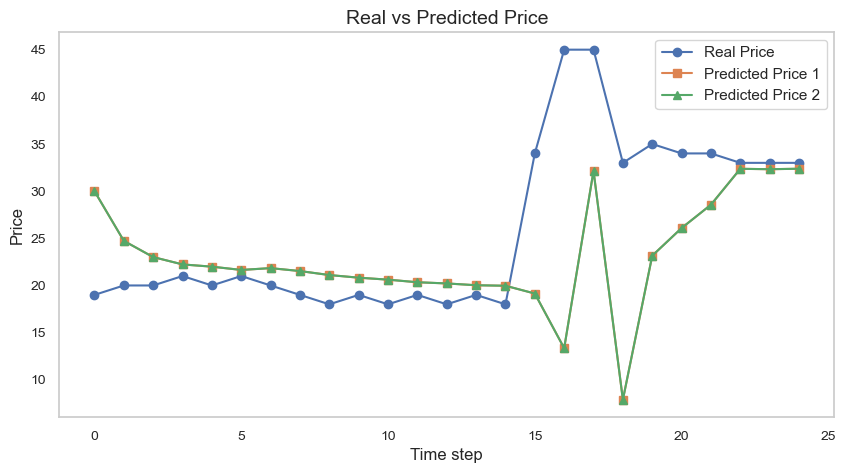

In [249]:
# 3) Andamento di real_price e predicted_price nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, real_price, label='Real Price', marker='o')
plt.plot(time, predicted_price1, label='Predicted Price 1', marker='s')
plt.plot(time, predicted_price2, label='Predicted Price 2', marker='^')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.title('Real vs Predicted Price')
plt.legend()
plt.grid()
plt.show()

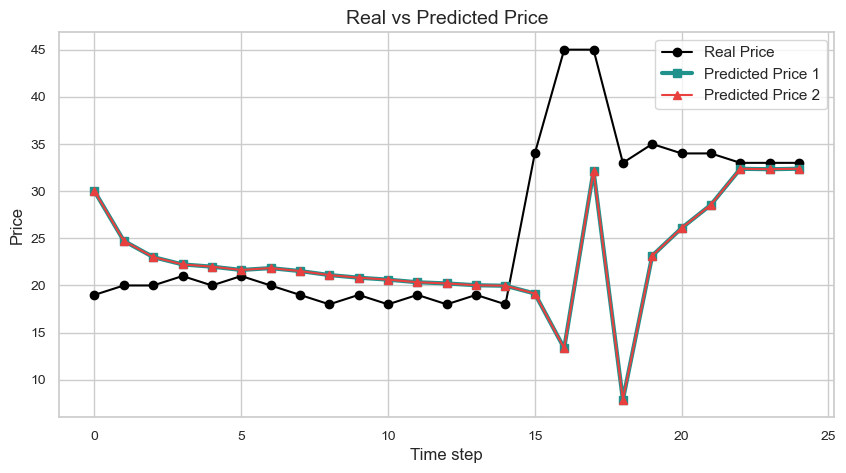

In [250]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Example time and price data (if needed for testing)
# time = np.arange(10)
# real_price = np.random.rand(10) * 100
# predicted_price1 = real_price + np.random.randn(10) * 5
# predicted_price2 = real_price + np.random.randn(10) * 5

# Select colors from colormaps
viridis_color = cm.viridis(0.5)   # A mid-to-light tone from viridis
rocket_color = cm.get_cmap('rocket')(0.6)  # A mid-value from rocket (requires seaborn or newer matplotlib)
real_color = 'black'  # Contrasting neutral color for ground truth

predicted_price1_ = np.array(predicted_price1)
# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, real_price, label='Real Price', marker='o', color=real_color)
plt.plot(time, predicted_price1_ , label='Predicted Price 1', marker='s', color=viridis_color, linewidth=3)
plt.plot(time, predicted_price2, label='Predicted Price 2', marker='^', color=rocket_color)
plt.xlabel('Time step')
plt.ylabel('Price')
plt.title('Real vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()
